# Racing Profile

Thinking about all the features that would go into a single observation. 
Observation unit: driver
Dependent variable: Grand Prix finishing position

Independent variables:??

    * Model 1: Features from Practice 1-3 and Qualifying
    * Model 2: Model 1 + features from first half of race
    * Model 3: Model 2 + features from past performance

What Features?

Model 1: Features from Practice 1-3 and Qualifying - Following features for each session (x4)

    * Min/Max/Avg lap times
    * Number of stints (stint_number max)
    * Sum of # of practice laps?
    * Summary stats for each lap? or stint? (break, rpm, throttle, speed, drs) (min/max/avg)
        * max break, min/max/avg rpm, max/avg throttle, min/max/avg speed
    * (Maybe) Number of gear changes (n_gear) 
    * Avg Pit duration
    * Number of Pits?


In [36]:
#| label: import
from urllib.request import urlopen
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

query_base = "https://api.openf1.org/v1/"

In [25]:

query_meeting = query_base+"meetings?year=2023&country_name=Belgium"

print(query_meeting)

response = urlopen(query_meeting)
data = json.loads(response.read().decode('utf-8'))
df = pd.json_normalize(data)

meeting_num = str(df['meeting_key'][0])

print(meeting_num)

https://api.openf1.org/v1/meetings?year=2023&country_name=Belgium
1216


In [93]:
query_meeting = query_base+"meetings?country_name=Belgium"

print(query_meeting)

response = urlopen(query_meeting)
data = json.loads(response.read().decode('utf-8'))
meeting_df = pd.json_normalize(data)

print(meeting_df.head())

https://api.openf1.org/v1/meetings?country_name=Belgium
         meeting_name                          meeting_official_name  \
0  Belgian Grand Prix  FORMULA 1 MSC CRUISES BELGIAN GRAND PRIX 2023   
1  Belgian Grand Prix        FORMULA 1 ROLEX BELGIAN GRAND PRIX 2024   

            location  country_key country_code country_name  circuit_key  \
0  Spa-Francorchamps           16          BEL      Belgium            7   
1  Spa-Francorchamps           16          BEL      Belgium            7   

  circuit_short_name                 date_start gmt_offset  meeting_key  year  \
0  Spa-Francorchamps  2023-07-28T11:30:00+00:00   02:00:00         1216  2023   
1  Spa-Francorchamps  2024-07-26T11:30:00+00:00   02:00:00         1242  2024   

  meeting_code  
0          NaN  
1          BEL  


In [98]:
query_drivers = query_base+"drivers?session_key=9134"

response = urlopen(query_drivers)
data = json.loads(response.read().decode('utf-8'))
driver_df = pd.json_normalize(data)

print(len(driver_df))

20


In [26]:
# get session numbers for practice and qualifiying, preloaded meeting_number for now
query_sessions = query_base+"sessions?meeting_key="+meeting_num

response = urlopen(query_sessions)
data = json.loads(response.read().decode('utf-8'))
df = pd.json_normalize(data)

# get just the session keys 
sessions = list(df['session_key'])
# remove the real race
del sessions[-1]
print(sessions)

[9134, 9135, 9286, 9140]


In [ ]:
# I'll just do one driver for now
driver_number = str(16)

# create features data frame
X = pd.DataFrame()

# create list of features for a individual driver
driver_feats = [driver_number]

session = sessions[0]

query_location = query_base+"location?driver_number="+driver_number+"&session_key="+str(session)

# call api and convert to df
response = urlopen(query_location)
data = json.loads(response.read().decode('utf-8'))
location_df = pd.json_normalize(data)

<Axes: xlabel='x', ylabel='y'>

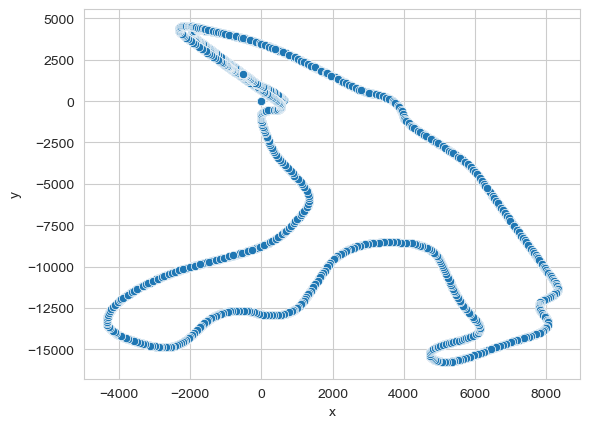

In [ ]:
sns.set_style("whitegrid")
sns.scatterplot(data =location_df, x = 'x', y = 'y') 

In [108]:
location_df['turn_num'] = "0"
total_turn_1 = 0

sub_location_df = location_df.loc[14000:15100,]

def turn_assign(row):
    if row['x'] > -2500 and row['x'] < -1700 and row['y'] > 3000 and row['y'] < 5000:
        return "1"
    elif row['x'] > 4300 and row['x'] < 5400 and row['y'] > -16500 and row['y'] < -14000:
        return "10"
    elif row['x'] > 5600 and row['x'] < 6300 and row['y'] > -14500 and row['y'] < -13000:
        return "11"
    else:
        return "0"
    

location_df['turn_num']  = location_df.apply(turn_assign, axis=1)

print((location_df['turn_num'] == "1").sum())
print((location_df['turn_num'] == "10").sum())
print((location_df['turn_num'] == "11").sum())



# for index, row in location_df.iterrows():
#     x = row['x']
#     y = row['y']
#     if (x >= -2200 & x <= -1900 & y >= 3000 & y <= 5000):
#         # print(1)
#         total_turn_1 = total_turn_1 + 1

245
224
131


In [53]:
# query for lap specific times
query_car = query_base+"car_data?driver_number="+driver_number+"&session_key="+str(session)

# call api for car data with lap time query
response = urlopen(query_car)
data = json.loads(response.read().decode('utf-8'))
car_df = pd.json_normalize(data)

In [54]:
print(car_df.head())

   driver_number  rpm  speed  n_gear  throttle  brake  drs  \
0             16    0      0       0         0      0    0   
1             16    0      0       0         0      0    0   
2             16    0      0       0         0      0    0   
3             16    0      0       0         0      0    0   
4             16    0      0       0         0      0    0   

                               date  session_key  meeting_key  
0  2023-07-28T11:15:39.679000+00:00         9134         1216  
1  2023-07-28T11:15:39.959000+00:00         9134         1216  
2  2023-07-28T11:15:40.159000+00:00         9134         1216  
3  2023-07-28T11:15:40.319000+00:00         9134         1216  
4  2023-07-28T11:15:40.559000+00:00         9134         1216  


36


In [ ]:
# I'll just do one driver for now
driver_number = str(16)

# create features data frame
X = pd.DataFrame()

# create list of features for a individual driver
driver_feats = [driver_number]


for session in sessions:
    # LAPS QUERY
    query_laps = query_base+"laps?driver_number="+driver_number+"&session_key="+str(session)

    # call api and convert to df
    response = urlopen(query_laps)
    data = json.loads(response.read().decode('utf-8'))
    laps_df = pd.json_normalize(data)

    # extract lap infor for current session
    min_lap = laps_df['lap_duration'].min()
    max_lap = laps_df['lap_duration'].max()
    avg_lap = float(round(laps_df['lap_duration'].mean(),3))
    num_laps = laps_df['lap_number'].max()

    # PARSE THE LAPS DATA BY TIME
    # laps_times_df will be used for car_data queries
    lap_times = laps_df[['lap_number','date_start','lap_duration']]

    # Convert date_start to datetime if it's not already in datetime format
    lap_times['date_start'] = pd.to_datetime(lap_times['date_start'])

    # use the next lap start as the end time exept for the last lap, which will be calculated with lap duration
    lap_times['date_end'] = lap_times['date_start'].shift(-1).fillna(lap_times['date_start'] + pd.to_timedelta(lap_times['lap_duration'], unit='s'))

    # convert back to string
    lap_times['date_start'] = lap_times['date_start'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f') + lap_times['date_start'].dt.strftime('%z').str[:3] + ':' + lap_times['date_start'].dt.strftime('%z').str[3:]
    lap_times['date_end'] = lap_times['date_end'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f') + lap_times['date_end'].dt.strftime('%z').str[:3] + ':' + lap_times['date_end'].dt.strftime('%z').str[3:]


    # LOOP THROUGH THE LAPS TO GET CAR DATA
    for lap in range(1,num_laps):
        lap_stats = []
        # base car data query for time filter to be added to
        query_car_base = query_base+"car_data?driver_number="+driver_number+"&session_key="+str(session)

        # create staret and end time for car data query
        start_time = lap_times[lap_times['lap_number']==lap]['date_start'].to_list()[0]
        end_time = lap_times[lap_times['lap_number']==lap]['date_end'].to_list()[0]

        # query for lap specific times
        query_car = query_car_base + "&date>="+str(start_time)+"&date<="+str(end_time)

        # call api for car data with lap time query
        response = urlopen(query_car)
        data = json.loads(response.read().decode('utf-8'))
        car_df = pd.json_normalize(data)

        # get summary stats for the lap
        max_break = car_df['brake'].max()
        max_rpm = car_df['rpm'].max()
        min_rpm = car_df['rpm'].min()
        avg_rpm = round(car_df['rpm'].mean())
        max_throttle = car_df['throttle'].max()
        avg_throttle = round(car_df['throttle'].mean())
        min_speed = car_df['speed'].min()
        max_speed = car_df['speed'].max()
        avg_speed = round(car_df['speed'].mean())

        # create list of car_data stats per lap
        car_data_list = [max_break, min_rpm, max_rpm, avg_rpm, max_throttle, avg_throttle, min_speed, max_speed, avg_speed]
        # add to laps stats
        lap_stats = lap_stats + car_data_list


    # STINTS QUERY
    query_stints = query_base + "stints?driver_number="+driver_number+"&session_key="+str(session)

    # call api and convert to df
    response = urlopen(query_stints)
    data = json.loads(response.read().decode('utf-8'))
    stints_df = pd.json_normalize(data)

    # extract max stint number
    num_stints = stints_df['stint_number'].max()


    # PTIS QUERY
    query_pits = query_base + "pit?driver_number="+driver_number+"&session_key="+str(session)

    # call api and convert to df
    response = urlopen(query_pits)
    data = json.loads(response.read().decode('utf-8'))
    pits_df = pd.json_normalize(data)

    # extract num of pits and avg pit duration
    num_pits = len(pits_df)
    avg_pit_time = float(round(pits_df['pit_duration'].mean(),1))


    # AFTER ALL QUERIES PER SESSION
    # append to driver features list
    driver_feats = driver_feats + [min_lap, max_lap, avg_lap, num_laps, num_stints] + [num_pits, avg_pit_time] + lap_stats


print(driver_feats)


/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000gn/T/ipykernel_8685/3027492163.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_times['date_start'] = pd.to_datetime(lap_times['date_start'])
/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000gn/T/ipykernel_8685/3027492163.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_times['date_end'] = lap_times['date_start'].shift(-1).fillna(lap_times['date_start'] + pd.to_timedelta(lap_times['lap_duration'], unit='s'))
/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000g

['16', 93.268, 888.191, 161.351, 24, 4, 4, 370.1, 100, 4823, 12081, 9476, 100, 42, 57, 312, 163, 91.113, 590.536, 148.184, 26, 4, 4, 319.0, 100, 3773, 12573, 9024, 100, 32, 34, 307, 145, 91.094, 789.228, 191.598, 17, 4, 4, 408.3, 100, 5298, 12333, 9283, 99, 33, 44, 299, 146, 89.165, 736.725, 202.377, 19, 7, 7, 280.4, 100, 5496, 12143, 10425, 99, 77, 66, 318, 217]


In [ ]:
print(len(driver_feats))

# colnames = ['min_lap_p1', 'max_lap_p1', 'avg_lap_p1', 'num_laps_p1, 'num_stints_p1', 'num_pits_p1', 'avg_pit_time_p1',
#             car_stats for each lap
#            'min_lap_p2', 'max_lap_p2', 'avg_lap_p2', 'num_laps_p2, 'num_stints_p2', 'num_pits_p2', 'avg_pit_time_p2',
#             car_stats for each lap
#            'min_lap_p3', 'max_lap_p3', 'avg_lap_p3', 'num_laps_p3, 'num_stints_p3', 'num_pits_p3', 'avg_pit_time_p3',
#             car_stats for each lap
#            'min_lap_q', 'max_lap_q', 'avg_lap_q', 'num_laps_q, 'num_stints_q','num_pits_q', 'avg_pit_time_q']

65


Working out the start time and end time per lap

In [148]:
session = 9467
query_laps = query_base+"laps?driver_number="+driver_number+"&session_key="+str(session)

# call api and convert to df
response = urlopen(query_laps)
data = json.loads(response.read().decode('utf-8'))
laps_df = pd.json_normalize(data)
# laps_df.head()

lap_times = laps_df[['lap_number','date_start','lap_duration']]

# Convert date_start to datetime if it's not already in datetime format
lap_times['date_start'] = pd.to_datetime(lap_times['date_start'])

# use the next lap start as the end time exept for the last lap, which will be calculated with lap duration
lap_times['date_end'] = lap_times['date_start'].shift(-1).fillna(lap_times['date_start'] + pd.to_timedelta(lap_times['lap_duration'], unit='s'))

# convert back to string
lap_times['date_start'] = lap_times['date_start'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f') + lap_times['date_start'].dt.strftime('%z').str[:3] + ':' + lap_times['date_start'].dt.strftime('%z').str[3:]
lap_times['date_end'] = lap_times['date_end'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f') + lap_times['date_end'].dt.strftime('%z').str[:3] + ':' + lap_times['date_end'].dt.strftime('%z').str[3:]

lap_times.head(20)

/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000gn/T/ipykernel_8685/2900679846.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_times['date_start'] = pd.to_datetime(lap_times['date_start'])
/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000gn/T/ipykernel_8685/2900679846.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_times['date_end'] = lap_times['date_start'].shift(-1).fillna(lap_times['date_start'] + pd.to_timedelta(lap_times['lap_duration'], unit='s'))
/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000g

,lap_number,date_start,lap_duration,date_end
0,1,2024-03-01T12:42:32.384000+00:00,NaN,2024-03-01T12:44:25.449000+00:00
1,2,2024-03-01T12:44:25.449000+00:00,92.677,2024-03-01T12:45:58.573000+00:00
2,3,2024-03-01T12:45:58.573000+00:00,146.339,2024-03-01T12:48:45.089000+00:00
3,4,2024-03-01T12:48:45.089000+00:00,148.363,2024-03-01T12:50:52.542000+00:00
4,5,2024-03-01T12:50:52.542000+00:00,92.025,2024-03-01T12:52:24.523000+00:00
5,6,2024-03-01T12:52:24.523000+00:00,130.847,2024-03-01T13:05:55.941000+00:00
6,7,2024-03-01T13:05:55.941000+00:00,789.228,2024-03-01T13:07:44.784000+00:00
7,8,2024-03-01T13:07:44.784000+00:00,92.693,2024-03-01T13:09:17.388000+00:00
8,9,2024-03-01T13:09:17.388000+00:00,146.232,2024-03-01T13:11:43.604000+00:00
9,10,2024-03-01T13:11:43.604000+00:00,100.083,2024-03-01T13:13:23.710000+00:00


Looking at car data for individual laps
* max break, min/max/avg rpm, max/avg throttle, min/max/avg speed

In [182]:
lap_num = 7

# base car data query for time filter to be added to
query_car_base = query_base+"car_data?driver_number="+driver_number+"&session_key="+str(session)

# create staret and end time for car data query
start_time = lap_times[lap_times['lap_number']==lap_num]['date_start'].to_list()[0]
end_time = lap_times[lap_times['lap_number']==lap_num]['date_end'].to_list()[0]

# query for lap specific times
query_car = query_car_base + "&date>="+str(start_time)+"&date<="+str(end_time)

# call api for car data with lap time query
response = urlopen(query_car)
data = json.loads(response.read().decode('utf-8'))
car_df = pd.json_normalize(data)
print(len(car_df))

max_break = car_df['brake'].max()
max_rpm = car_df['rpm'].max()
min_rpm = car_df['rpm'].min()
avg_rpm = round(car_df['rpm'].mean())
max_throttle = car_df['throttle'].max()
avg_throttle = round(car_df['throttle'].mean())
min_speed = car_df['speed'].min()
max_speed = car_df['speed'].max()
avg_speed = round(car_df['speed'].mean())

car_data_list = [max_break, min_rpm, max_rpm, avg_rpm, max_throttle, avg_throttle, min_speed, max_speed, avg_speed]

print(car_data_list)


2758
[104, 0, 12084, 2014, 104, 79, 0, 276, 26]
